# Fig. 5

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib
import xarray as xr 
import seaborn as sns

plt.rcParams['figure.figsize'] = [10,10]
plt.rcParams.update({'font.size': 20})

import warnings
warnings.filterwarnings("ignore")


## Funtions 

In [2]:
def another_mask(ds, cutoff, dlat=0.3, dlon=0.5, use_tracer=True):
    """
    Applies a mask to the dataset based on latitude, longitude, and a threshold quantile height.

    Parameters:
    ds (xarray.Dataset): The dataset to be masked.
    cutoff (float): The threshold factor for determining the mask.
    dlat (float): The latitude range around -36° for the mask (default is 0.3).
    dlon (float): The longitude range around 146.5° for the mask (default is 0.5).
    use_tracer (bool): If True, use the "Qpassive_1" tracer for calculation; otherwise, use density (default is True).

    Returns:
    xarray.Dataset: The dataset with an additional 'ao_mask' variable.
    """
    # Apply the initial geographical mask based on latitude and longitude
    ds_masked = ds.where(
        (ds.lat >= -36 - dlat) & (ds.lat <= -36 + dlat) & 
        (ds.lon >= 146.5 - dlon) & (ds.lon <= 146.5 + dlon),
        other=np.nan
    )

    # Apply the mask based on quantile height (5th percentile)
    ds_masked2 = ds_masked.where(
        ds.height > quantile_height(ds, quantile=0.05),
        other=np.nan
    )

    # Calculate flux based on the tracer or density
    if use_tracer:
        qflux = ds_masked2["w_intp"] * ds_masked2["Qpassive_1"]
    else:
        qflux = ds_masked2["w_intp"] * dens(ds_masked2)

    # Determine the maximum flux and apply the cutoff factor
    qmax = qflux.max(("lon", "lat"))
    threshold = qmax * cutoff
    aomask = qflux > threshold

    # Assign the mask to the dataset
    ds['ao_mask'] = (("time", "height", "lat", "lon"), aomask.data)

    return ds

def quantile_height(ds, var="Qpassive_1", quantile=0.05):
    """
    Calculates the height above which a specified quantile percentage of the given variable are located.
    Primarily used with 'Qpassive_1' to determine the injection height.

    Parameters:
    ds (xarray.Dataset): The dataset containing the variable of interest.
    var (str): The variable name to use for calculation (default is "Qpassive_1").
    quantile (float): The quantile value (e.g., 0.05 for 5%) to determine the height threshold (default is 0.05).

    Returns:
    xarray.DataArray: The minimum height where the specified quantile condition is met.
    """
    
    ds = ds.mean(("lat", "lon"))
    rho = dens(ds)
    dz = -1 * z.differentiate("height")
    qplume = ds[var] * rho.values * dz.values
    qplume_sum = qplume.cumsum(dim="height")
    qplume_100 = qplume_sum.max(dim="height")
    qplume_q = qplume_100 * quantile
    height_q = ds['height'].where(qplume_q < qplume_sum)
    height_q_min = height_q.min(dim="height")

    return height_q_min


def dens(d): 
    R = 287.1
    densitiy = d.pres / (R * d.temp)
    return densitiy



def cloud_base(dset):
    """
    Finds the cloud base height where the 'qc' variable exceeds a certain threshold.

    Parameters:
    dset (xarray.Dataset): The dataset containing the 'qc' variable and a mask called 'inner_mask'.

    Returns:
    xarray.DataArray: The height at which 'qc' exceeds the threshold.
    """
    # Apply the mask to the dataset
    dset = dset.where(dset.inner_mask, np.nan)

    # Calculate the mean across the 'lon' and 'lat' dimensions
    data = dset.mean(("lon", "lat"))

    # Find 'qc' values that exceed the threshold (0.0002)
    qc_above_threshold = data['qc'].where(data['qc'] > 0.0002).values

    # Find the indices where 'qc' is not NaN
    valid_indices = np.where(~np.isnan(qc_above_threshold))

    # Find the highest valid index for the cloud base
    if valid_indices[0].size > 0:  # Ensure there is a valid index
        highest_index = np.max(valid_indices)
        highest_height = dset.height.isel(height=highest_index)
    else:
        highest_height = np.nan  # Return NaN if no valid index is found

    return highest_height



def more_vars(ds):
    """
    Calculates additional thermodynamic variables and adds them to the dataset.

    Parameters:
    ds (xarray.Dataset): The dataset containing temperature and water vapor data.

    Returns:
    xarray.Dataset: The original dataset with additional variables for analysis.
    """
    # Constants for calculations
    p0 = 100000  # Reference pressure in hPa
    lv_const_a = 2500.78  # Latent heat constant (a)
    lv_const_b = 2.32573  # Latent heat constant (b)
    Rd = 287.04  # Specific gas constant for dry air (J/(kg·K))
    cp = 1004.82  # Specific heat capacity at constant pressure (J/(kg·K))
    cw = 4186.74  # Specific heat capacity of water (J/(kg·K))

    # Calculate the mixing ratio of water vapor
    r = ds.qv / (1 - ds.qv)

    # Calculate the latent heat of vaporization (lv)
    lv = lv_const_a - (ds.temp * lv_const_b)

    # Calculate equivalent potential temperature (theta_ae)
    theta_ae = (ds.temp + r * (lv / (cp + r * cw))) * ((p0 / ds.pres) ** (Rd / cp))
    ds["theta_ae"] = theta_ae

    # Calculate potential temperature (tpot)
    tpot = ds.temp * ((p0 / ds.pres) ** (Rd / cp))
    ds["tpot"] = tpot

    # Add the mixing ratio as a variable to the dataset
    ds["r"] = r

    # Calculate and add density to the dataset
    ds["dens"] = dens(ds)

    # Calculate total water content and condensed water content
    ds["qtotal"] = ds.qc + ds.qi + ds.qg + ds.qs + ds.qh + ds.qr + ds.qv
    ds["qcondens"] = ds.qc + ds.qi + ds.qg + ds.qs + ds.qh + ds.qr

    return ds

In [3]:
def override_height(ds, z):
    return ds.assign_coords(height=z.values)

## Get Data

In [4]:
data_path = "../data/"
dsref = xr.open_mfdataset(data_path + "exp_ref.nc", engine = 'netcdf4').isel(time = slice(2,None)).mean("time").squeeze()
dsref = more_vars(dsref)

z = xr.open_mfdataset("./height_info.nc").mean("time").squeeze().mean(("lat", "lon"))["z_mc"]/1000
dsref = override_height(dsref,z)

In [5]:
cut = 0.05

ds13 = override_height(xr.open_mfdataset(data_path + "exp_013.nc", engine = 'netcdf4').isel(time = slice(3,None)).squeeze(),z)
ds17 = override_height(xr.open_mfdataset(data_path + "exp_017.nc", engine = 'netcdf4').isel(time = slice(3,None)).squeeze(),z)
ds21 = override_height(xr.open_mfdataset(data_path + "exp_021.nc", engine = 'netcdf4').isel(time = slice(3,None)).squeeze(),z)
ds28 = override_height(xr.open_mfdataset(data_path + "exp_028.nc", engine = 'netcdf4').isel(time = slice(3,None)).squeeze(),z)

dsets = [ds13, ds17, ds21,ds28]

## Prepare Plot

In [6]:
for ds in dsets:
    ds = more_vars(ds)
    ds = another_mask(ds, cut)

unit = f"$\,$kW$\,$m$^-$$^2$"
set_names = [  "75" + unit, "100" + unit, "150"+ unit, "200"+ unit]

In [7]:
# Initialize an array to store cloud base values for each dataset
cbase = np.zeros(len(dsets))

# Loop over each dataset in the list
for i, ds in enumerate(dsets):
    # Calculate the potential temperature, mask with 'ao_mask', and take the mean over specified dimensions
    dtpot = ds["tpot"].where(ds.ao_mask).mean(("lon", "lat")).mean("time")
    
    # Reverse the height order and differentiate with respect to height
    dtpot = dtpot[::-1].differentiate("height")
    
    # Apply a rolling mean with a window size of 5
    dtopot = dtpot.rolling(height=5).mean()
    
    # Find the closest value to zero in the rolling mean and extract its coordinate
    closest_value = dtopot.where(np.abs(dtopot.compute()) == np.abs(dtopot.compute()).min(), drop=True)
    cbase[i] = closest_value.coords[dtopot.dims[0]].values
    
# Optionally, print a summary at the end
print("Cloud base values for all datasets:", cbase)

Cloud base values for all datasets: [3.93260479 4.05755043 4.31262636 4.44277382]


In [8]:
tops = np.zeros(len(dsets))

# Iterate over each dataset in the list
for i, ds in enumerate(dsets):
    # Calculate the mean pressure profile over specified dimensions and apply the mask
    profile = ds["pres"].where(ds.ao_mask).mean(("lon", "lat")).mean("time")
    
    # Find the height corresponding to the minimum pressure value and store it
    tops[i] = profile.height.where(profile == profile.min()).max()

    # Print the current index for progress tracking
    print(f"Processing dataset {i + 1}...")

# Optionally, print a summary at the end
print("Top pressure values for all datasets:", tops)

Processing dataset 1...
Processing dataset 2...
Processing dataset 3...
Processing dataset 4...
Top pressure values for all datasets: [17.43110657 17.43110657 17.75087738 18.07847023]


## Finally the plot

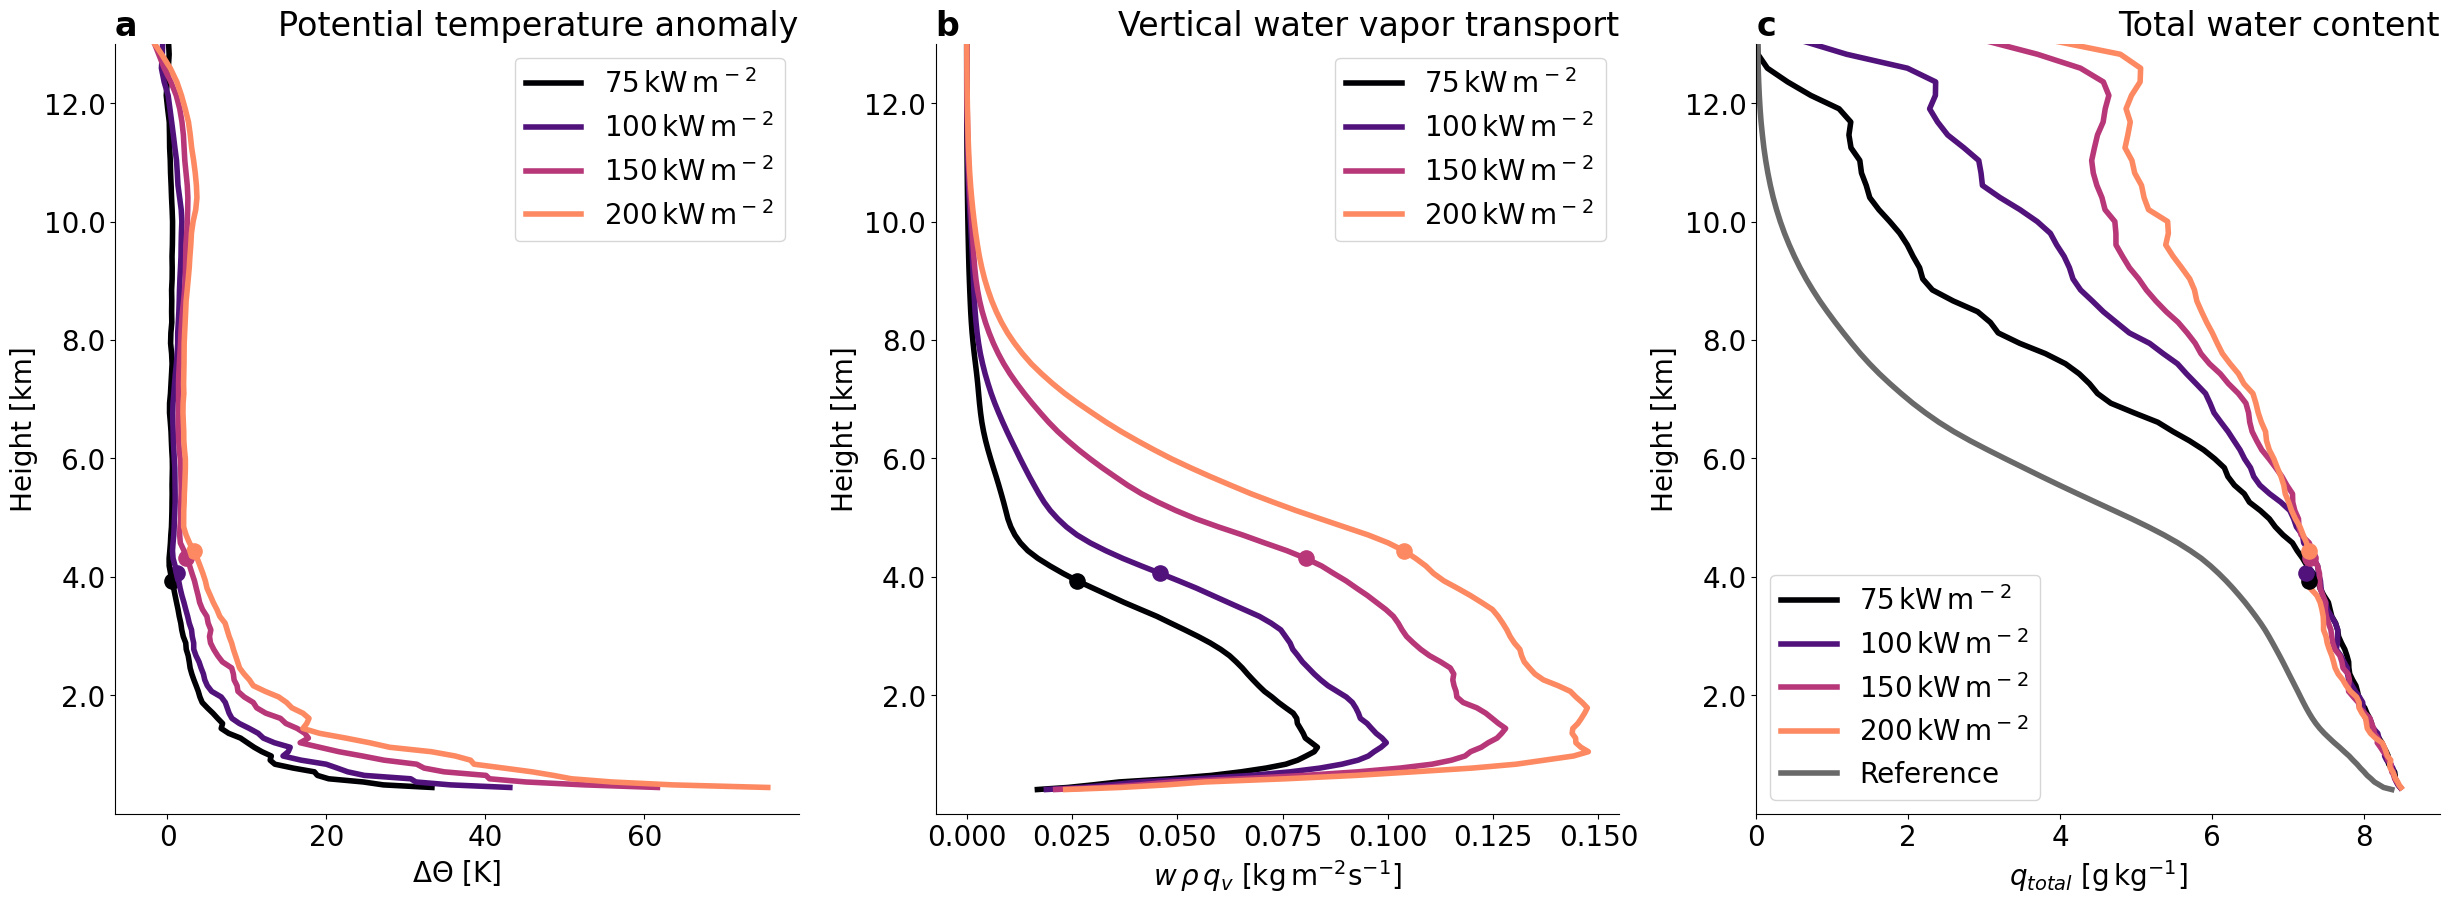

In [9]:
# Define constants and set up the colormap
y_ticks = np.arange(2,12.1,2)
colormap = plt.cm.magma
colors = [colormap(i / len(dsets)) for i in range(len(dsets))]
ymin = 0
ymax = 13
line_width = 4
line_width2 = 2
ref = dsref.mean(("lon", "lat"))

# Create the figure and axis grid for subplots
fig, axis = plt.subplots(1, 3, figsize=[30, 10])

# List to hold handles and labels for the legends
handles_legend1, labels_legend1 = [], []
handles_legend3, labels_legend3 = [], []

### First subplot (Potential temperature)
if True:
    ax = axis[0]
    for i, ds in enumerate(dsets):
        # Calculate the potential temperature values and plot
        values = (ds["tpot"]).where(ds.ao_mask).mean(("lon", "lat")).mean("time") - ref["tpot"].values
        ax.plot(values, ds.height, color=colors[i], linewidth=line_width, label=set_names[i])
    
        # Scatter plot for cloud base and top values
        ax.scatter(values.sel(height=cbase[i]), cbase[i], color=colors[i], s=120, marker="o")
        #ax.scatter(values.sel(height=tops[i]), tops[i], color=colors[i], s=120, marker="o")
    
    
    # Set title, labels, and customize axes
    ax.set_title("Potential temperature anomaly", loc="right")
    ax.set_title("a", fontweight='bold', loc="left")
    ax.set_xlabel(r"$\Delta \Theta$ [K]")
    # ax.set_xlim(312, 430)
    ax.legend(loc='upper right')

### Second subplot (Vertical water vapor transport)
if True:
    ax = axis[1]
    for i, ds in enumerate(dsets):
        # Calculate the vertical water vapor transport and plot
        values = (ds["w_intp"] * ds["dens"] * ds["qv"]).where(ds.ao_mask).mean(("lon", "lat")).mean("time")
        values = values.rolling(height=5, center=True, min_periods=1).mean()
        ax.plot(values, ds.height, label=set_names[i], color=colors[i], linewidth=line_width)
    
        # Scatter plot for cloud base and top values
        ax.scatter(values.sel(height=cbase[i]), cbase[i], color=colors[i], s=120, marker="o")
    
    # Add legend for vertical water vapor transport
    ax.legend(handles=handles_legend1, labels=labels_legend1, loc='upper right')
    
    # Set title, labels, and customize axes
    ax.set_title("Vertical water vapor transport", loc="right")
    ax.set_title("b", fontweight='bold', loc="left")
    ax.set_xlabel(r"$w\,\rho\,q_{v}$ [kg$\,$m$^{-2}$s$^{-1}$]")

### Third subplot (Total water content)
if True:
    ax = axis[2]
    # Define specific datasets for total water content
    for i, ds in enumerate(dsets):
        values  = (ds["qtotal"].where(ds.ao_mask).mean(("lon", "lat")).mean("time")) * 1000
        ax.plot(values, ds.height, label=set_names[i], color=colors[i], linewidth=line_width,  zorder=1)
        
    for i, ds in enumerate(dsets):
        ax.scatter(values.sel(height=cbase[i]), cbase[i], color=colors[i], s=120, marker="o", zorder=2)
    
    qcref = dsref["qtotal"].mean(("lon", "lat")) * 1000
    ax.plot(qcref, ds.height, color="dimgrey", label="Reference", linewidth = line_width)
    
    # Set title, labels, and customize axes
    ax.set_title("Total water content", loc="right")
    ax.set_title("c", fontweight='bold', loc="left")
    ax.set_xlabel(r"$q_{total}$ [g$\,$kg$^{-1}$]")
    
    # Add legend for total water content
    ax.legend(loc="lower left")
    ax.set_xlim(0, 9)

### Common customizations for all subplots
for ax in axis:
    ax.set_ylim(ymin, ymax)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_ticks)
    ax.set_ylabel("Height [km]")
    sns.despine(ax=ax)

# Save the figure
my_path = "./figs/"
fig.savefig(my_path + 'fig05.png', dpi=300, bbox_inches='tight')
fig.savefig(my_path + 'fig05_lq.png', dpi=50, bbox_inches='tight')


In [10]:
# Difference in Potential Temperature at 600hPa
print("Potential Temperatures at 4km")
for ds in dsets:
    print(((ds["tpot"]).where(ds.ao_mask).mean(("lon", "lat")).mean("time").sel(height = 4, method = "nearest")).values)
# Difference in Potential Temperature at 400hPa
print("Potential Temperatures at 8km")
for ds in dsets:
    print(((ds["tpot"]).where(ds.ao_mask).mean(("lon", "lat")).mean("time").sel(height = 8, method = "nearest")).values)

Potential Temperatures at 4km
316.16441284835247
316.95584034239994
318.86072284884665
320.22927772958144
Potential Temperatures at 8km
332.12123274496645
333.0180078806391
333.3679854570623
333.82871085621736
